# LayerNorm Geometric Exploration

Paper: https://arxiv.org/pdf/2405.04134 

LayerNorm is a key building block in modern neural networks like transformers, however its geometric implications are often overlooked! This paper breaks it down into four simple steps:

+ Projection - LayerNorm first centers your data by subtracting the mean from each activation vector. This projects your data onto a plane where all points sum to zero.
+ Scaling - It then normalizes the centered vectors by dividing by their standard deviation (plus a small epsilon for stability). This makes all points lie within a sphere.
+ Stretching - The model applies learned "gain" parameters to stretch the sphere into an ellipsoid shape, emphasising certain directions more than others.
+ Shifting - Finally, it adds a learned "bias" vector to move the entire ellipsoid to a new position.

The visualization below shows this process in 3D, where we can see points starting as a scattered cloud, then getting projected onto a hyperplane, and finally being normalized to lie on the intersection of the hyperplane and hyperellipsoid. In higher dimensions, the same principles apply - LayerNorm maps inputs to an (N-1)-dimensional ellipsoid.

In [2]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [3]:

class LayerNorm(nn.Module):
    eps: float = 1e-5
    
    @nn.compact
    def __call__(self, x):
        # Project onto hyperplane
        mean = jnp.mean(x, axis=-1, keepdims=True)

        # 
        x_centered = x - mean
        
        # Step 2: Scale to lie within N-ball
        var = jnp.var(x, axis=-1, keepdims=True, ddof=0)
        x_normalized = x_centered / jnp.sqrt(var + self.eps)
        
        return x_normalized, x_centered

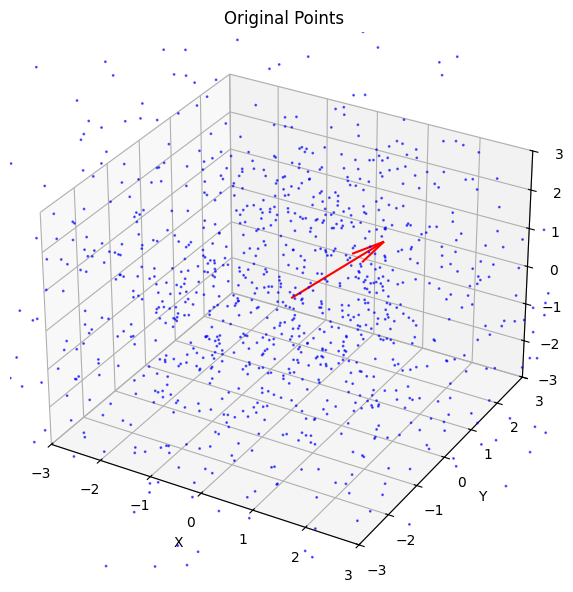

In [4]:
# Set random seed for reproducibility
key = jax.random.PRNGKey(0)

# Generate random 3D points
n_points = 1000
points = jax.random.normal(key, (n_points, 3)) * 2

# Initialize LayerNorm
layer_norm = LayerNorm()
variables = layer_norm.init(key, points)

# Pass the points through the LayerNorm module
points_normalized, points_centered = layer_norm.apply(variables, points)

# Convert to numpy for plotting
points = np.array(points)
points_centered = np.array(points_centered)
points_normalized = np.array(points_normalized)

# Plot 1: Original points
fig1 = plt.figure(figsize=(8, 6))
ax1 = fig1.add_subplot(111, projection='3d')
ax1.scatter(points[:, 0], points[:, 1], points[:, 2], c='b', alpha=0.6, s=1)
ax1.set_title('Original Points')

# Add unit vector in direction [1,1,1] to show projection axis
origin = np.zeros(3)
ones_vector = np.ones(3) / np.sqrt(3)
ax1.quiver(origin[0], origin[1], origin[2],
            ones_vector[0], ones_vector[1], ones_vector[2],
            color='r', length=2, label='[1,1,1] direction')

# Set axis limits and labels
ax1.set_xlim([-3, 3])
ax1.set_ylim([-3, 3])
ax1.set_zlim([-3, 3])
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')

plt.tight_layout()
plt.show()


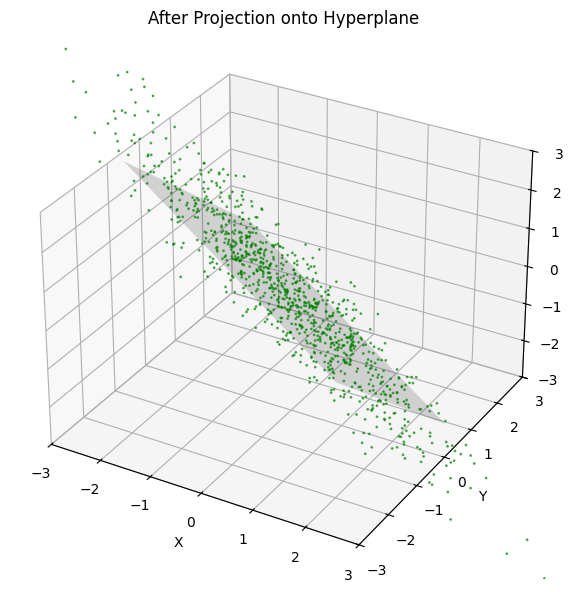

In [5]:

# Projection onto Hyperplane
fig2 = plt.figure(figsize=(8, 6))
ax2 = fig2.add_subplot(111, projection='3d')
ax2.scatter(points_centered[:, 0], points_centered[:, 1], 
            points_centered[:, 2], c='g', alpha=0.6, s=1)
ax2.set_title('After Projection onto Hyperplane')

# Plot plane perpendicular to [1,1,1]
xx, yy = np.meshgrid(np.linspace(-2, 2, 10), np.linspace(-2, 2, 10))
a, b, c = 1/np.sqrt(3), 1/np.sqrt(3), 1/np.sqrt(3)  # Normal vector components
d = 0  # Distance from origin
zz = -(a*xx + b*yy - d)/c
ax2.plot_surface(xx, yy, zz, alpha=0.2, color='gray')

# Set axis limits and labels
ax2.set_xlim([-3, 3])
ax2.set_ylim([-3, 3])
ax2.set_zlim([-3, 3])
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')

plt.tight_layout()
plt.show()


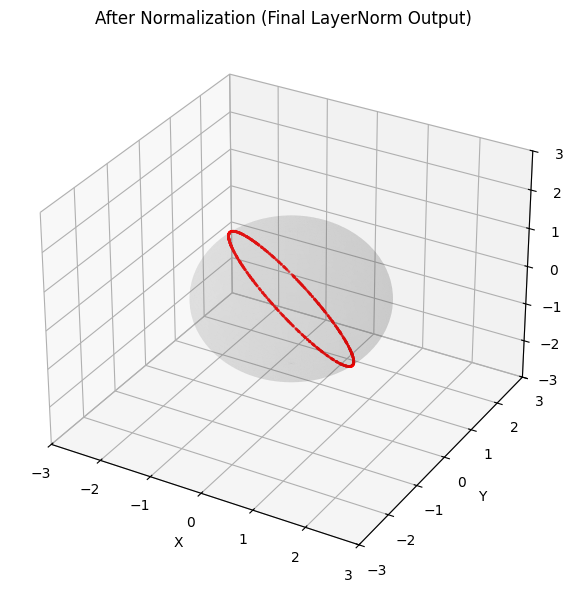

In [6]:
# Normalize to lie within N-ball
fig3 = plt.figure(figsize=(8, 6))
ax3 = fig3.add_subplot(111, projection='3d')
ax3.scatter(points_normalized[:, 0], points_normalized[:, 1],
            points_normalized[:, 2], c='r', alpha=0.6, s=1)
ax3.set_title('After Normalization (Final LayerNorm Output)')

# Add sphere to show the normalization constraint
r = np.sqrt(3)  # radius = sqrt(N) as per paper
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = r * np.outer(np.cos(u), np.sin(v))
y = r * np.outer(np.sin(u), np.sin(v))
z = r * np.outer(np.ones(np.size(u)), np.cos(v))
ax3.plot_surface(x, y, z, color='gray', alpha=0.1)

# Set axis limits and labels
ax3.set_xlim([-3, 3])
ax3.set_ylim([-3, 3])
ax3.set_zlim([-3, 3])
ax3.set_xlabel('X')
ax3.set_ylabel('Y')
ax3.set_zlabel('Z')

plt.tight_layout()
plt.show()